# PROBLEM STATEMENT:

<h3>
<ol>
    <li>In bike-sharing systems, the entire process from membership to rental and return has been automated. Using these systems, users can easily rent a bike from one location and return it to another. </li> <br><br>
    <li>Hence, a bike rental company want to predict the number of bikes rented on a daily basis, depending on the environment and the seasons.</li>
</ol>
</h3>

### Loading the required libraries

In [15]:
library(corrplot)
library(ggplot2)
library(dplyr)
library(rcompanion)
library(mlr)
library(caTools)
library(MASS)
library(Metrics)
library(randomForest)

### Loading the data

In [16]:
data <- read.csv("C:\\Users\\DELL\\Desktop\\1657875746_day.csv", header = TRUE)

In [17]:
head(data)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
,<int>,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,01-01-2011,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.1604460,331,654,985
2,2,02-01-2011,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.2485390,131,670,801
3,3,03-01-2011,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.2483090,120,1229,1349
4,4,04-01-2011,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.1602960,108,1454,1562
5,5,05-01-2011,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.1869000,82,1518,1600
6,6,06-01-2011,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.0895652,88,1518,1606


### Basic Information of the Data

In [46]:
sprintf('There are %s rows (i.e. observations) and %s columns (i.e. variables) in the Bike data', dim(data)[1], dim(data)[2])

[1] "There are 731 rows (i.e. observations) and 16 columns (i.e. variables) in the Bike data"

In [19]:
str(data)

'data.frame':	731 obs. of  16 variables:
 $ instant   : int  1 2 3 4 5 6 7 8 9 10 ...
 $ dteday    : chr  "01-01-2011" "02-01-2011" "03-01-2011" "04-01-2011" ...
 $ season    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ yr        : int  0 0 0 0 0 0 0 0 0 0 ...
 $ mnth      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ holiday   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ weekday   : int  6 0 1 2 3 4 5 6 0 1 ...
 $ workingday: int  0 0 1 1 1 1 1 0 0 1 ...
 $ weathersit: int  2 2 1 1 1 1 2 2 1 1 ...
 $ temp      : num  0.344 0.363 0.196 0.2 0.227 ...
 $ atemp     : num  0.364 0.354 0.189 0.212 0.229 ...
 $ hum       : num  0.806 0.696 0.437 0.59 0.437 ...
 $ windspeed : num  0.16 0.249 0.248 0.16 0.187 ...
 $ casual    : int  331 131 120 108 82 88 148 68 54 41 ...
 $ registered: int  654 670 1229 1454 1518 1518 1362 891 768 1280 ...
 $ cnt       : int  985 801 1349 1562 1600 1606 1510 959 822 1321 ...


### Handling Missing Values

In [53]:
sprintf("There are %s missing values in the dataset", sum(is.na(data)))

[1] "There are 0 missing values in the dataset"

<h3>
    OBSERVATIONS:
<ol>
<li>There are many variables in the dataset and the type of those variables is listed above. Note that they all are not in an organized format.</li><br><br>
<li>The variable 'season' has an integer data type and has observations ranging from 1 to 4, rather than displaying the seasons. The observations need to be converted into "spring", "summer", "fall" and "winter".</li><br><br>
<li>Similarly, the variable 'yr' displays the observations for year as 0 and 1, which should be 2011 and 2012 respectively. </li><br><br>
<li>The variable 'holiday' takes the values 0 and 1, which indicate 'no holiday' and 'holiday taken' respectively. </li>
<li>And, there is 'weathersit' which also has integer data type, displaying values 1, 2, 3 and 4. That needs to be converted, thinking in terms of ratings in the descending order, into "Clear" (i.e. few clouds, partly cloudy), "Mist" (i.e. broken clouds and misty), "Light Rain" (i.e. thunderstorm, scattered clouds) and "Heavy Rain" (i.e. ice pallets, lightning, thunderstorm).</li>
</ol>
</h3>

## Handling Factors: converting the categorical variables

In [21]:
data$mnth <- as.factor(data$mnth)
data$holiday <- as.factor(data$holiday)
data$weekday <- as.factor(data$weekday)
data$workingday <- as.factor(data$workingday)

In [22]:
data$season <- as.factor(data$season)
levels(data$season)[levels(data$season) == 1] <- 'springer'
levels(data$season)[levels(data$season) == 2] <- 'summer'
levels(data$season)[levels(data$season) == 3] <- 'fall'
levels(data$season)[levels(data$season) == 4] <- 'winter'

In [23]:
data$yr <- as.factor(data$yr)
levels(data$yr)[levels(data$yr) == 0] <- 2011
levels(data$yr)[levels(data$yr) == 1] <- 2012

In [24]:
data$weathersit <- as.factor(data$weathersit)
levels(data$weathersit)[levels(data$weathersit) == 1] <- 'Good'
levels(data$weathersit)[levels(data$weathersit) == 2] <- 'Cloudy'
levels(data$weathersit)[levels(data$weathersit) == 3] <- 'Bad'

#                       EXPLORATORY DATA ANALYSIS                

## Outlier Analysis                  

In [25]:
outlierKD <- function(dt, var) {
   var_name <- eval(substitute(var), eval(dt))
   na1 <- sum(is.na(var_name))
   m1 <- mean(var_name, na.rm = T)
   par(mfrow = c(2, 2), oma = c(0, 0, 3, 0))
   boxplot(var_name, main = "With outliers")
   hist(var_name,
        main = "With outliers",
        xlab = NA,
        ylab = NA)
   outlier <- boxplot.stats(var_name)$out
   mo <- mean(outlier)
   var_name <- ifelse(var_name %in% outlier, NA, var_name)
   boxplot(var_name, main = "Without outliers")
   hist(var_name,
        main = "Without outliers",
        xlab = NA,
        ylab = NA)
   title("Outlier Check", outer = TRUE)
   na2 <- sum(is.na(var_name))
   cat("Outliers identified:", na2 - na1, "n")
   cat("Propotion (%) of outliers:", round((na2 - na1) / sum(!is.na(var_name)) *
                                              100, 1), "n")
   cat("Mean of the outliers:", round(mo, 2), "n")
   m2 <- mean(var_name, na.rm = T)
   cat("Mean without removing outliers:", round(m1, 2), "n")
   cat("Mean if we remove outliers:", round(m2, 2), "n")
   
}

Outliers identified: 0 nPropotion (%) of outliers: 0 nMean of the outliers: NaN nMean without removing outliers: 0.5 nMean if we remove outliers: 0.5 n

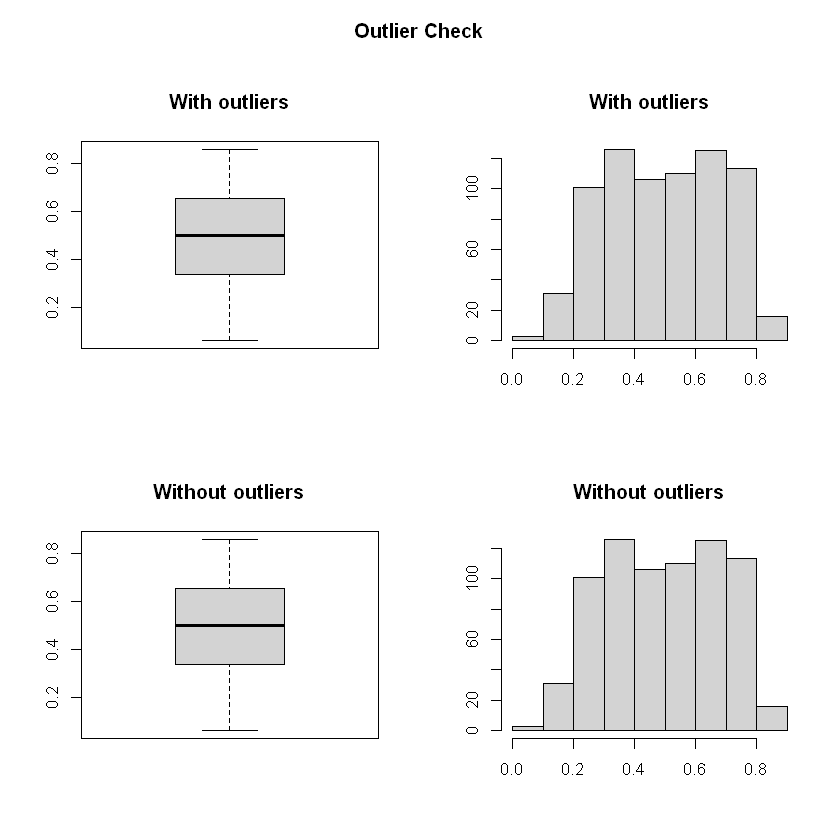

In [26]:
outlierKD(data, temp) #no outliers

Outliers identified: 0 nPropotion (%) of outliers: 0 nMean of the outliers: NaN nMean without removing outliers: 0.47 nMean if we remove outliers: 0.47 n

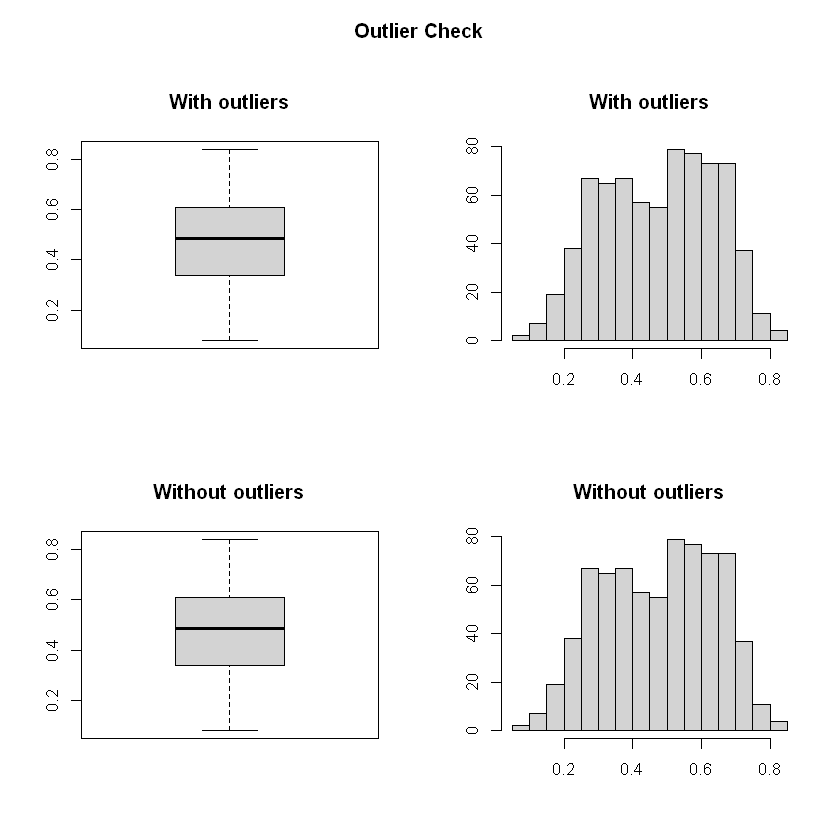

In [27]:
outlierKD(data, atemp) #no outliers

Outliers identified: 2 nPropotion (%) of outliers: 0.3 nMean of the outliers: 0.09 nMean without removing outliers: 0.63 nMean if we remove outliers: 0.63 n

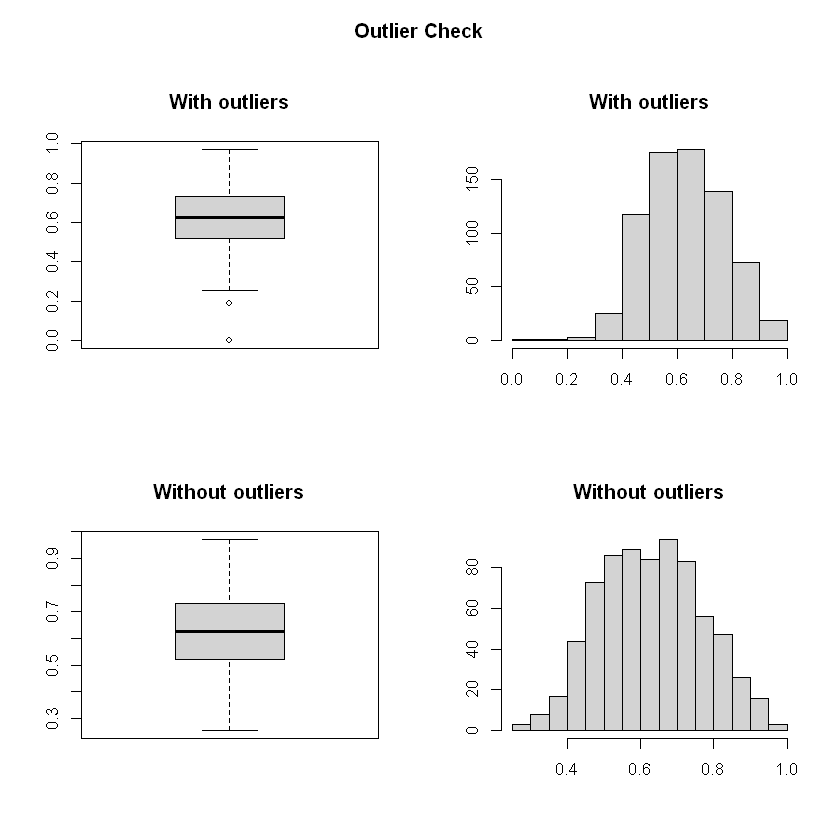

In [28]:
outlierKD(data, hum) # no extreme outlier detected

Outliers identified: 13 nPropotion (%) of outliers: 1.8 nMean of the outliers: 0.42 nMean without removing outliers: 0.19 nMean if we remove outliers: 0.19 n

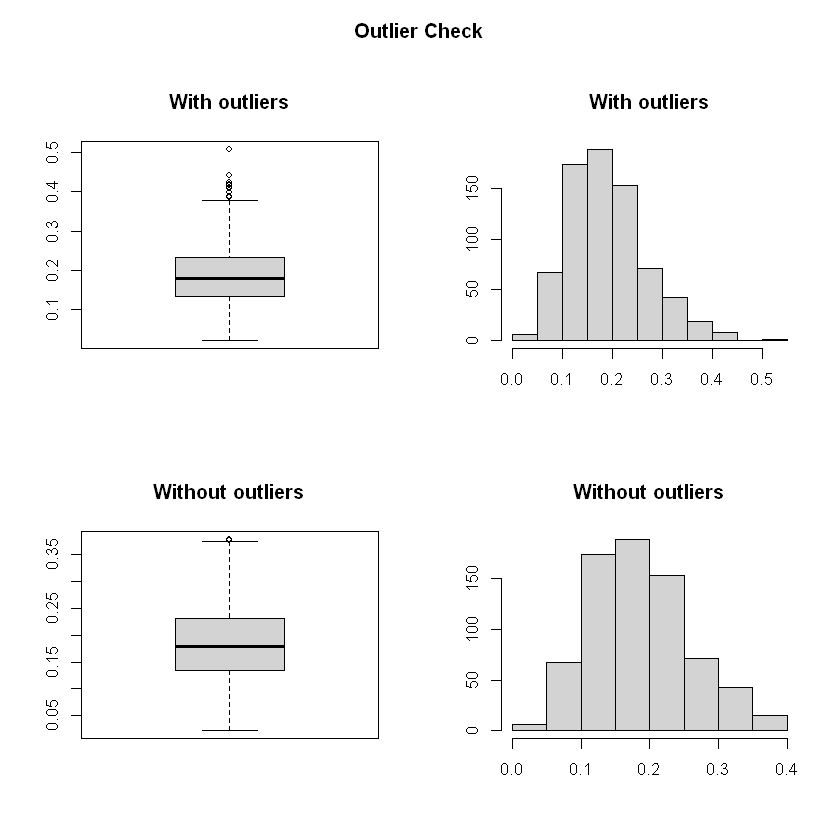

In [29]:
outlierKD(data, windspeed) #some extreme values are present but canot be considered as outlier

Outliers identified: 13 nPropotion (%) of outliers: 1.8 nMean of the outliers: 0.42 nMean without removing outliers: 0.19 nMean if we remove outliers: 0.19 n

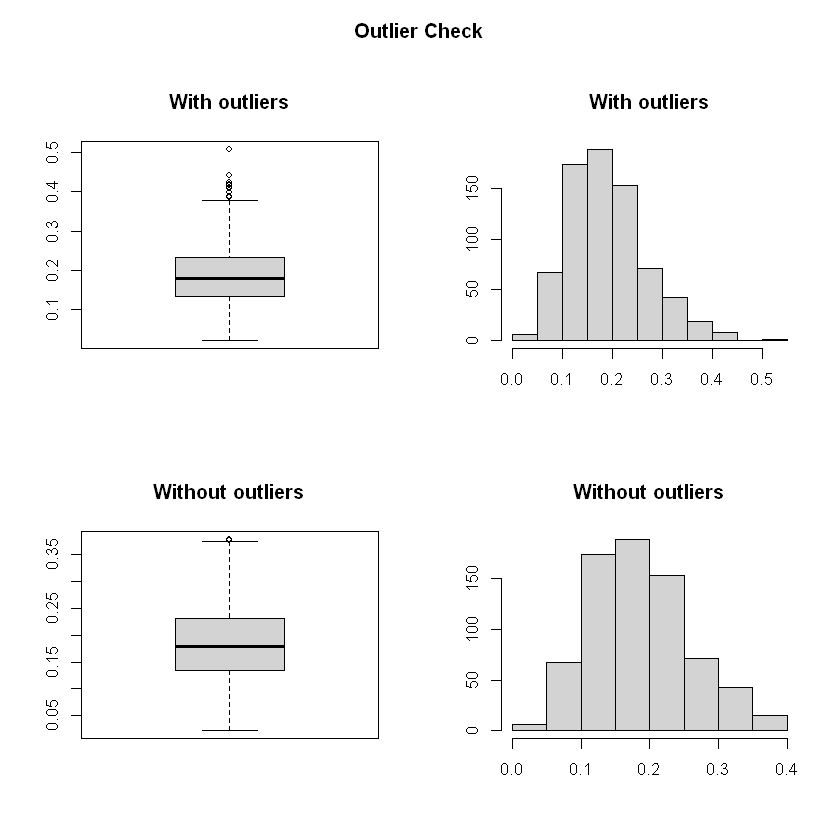

In [30]:
outlierKD(data, windspeed) #some extreme values are present but canot be considered as outlier

Outliers identified: 44 nPropotion (%) of outliers: 6.4 nMean of the outliers: 2661.95 nMean without removing outliers: 848.18 nMean if we remove outliers: 732.01 n

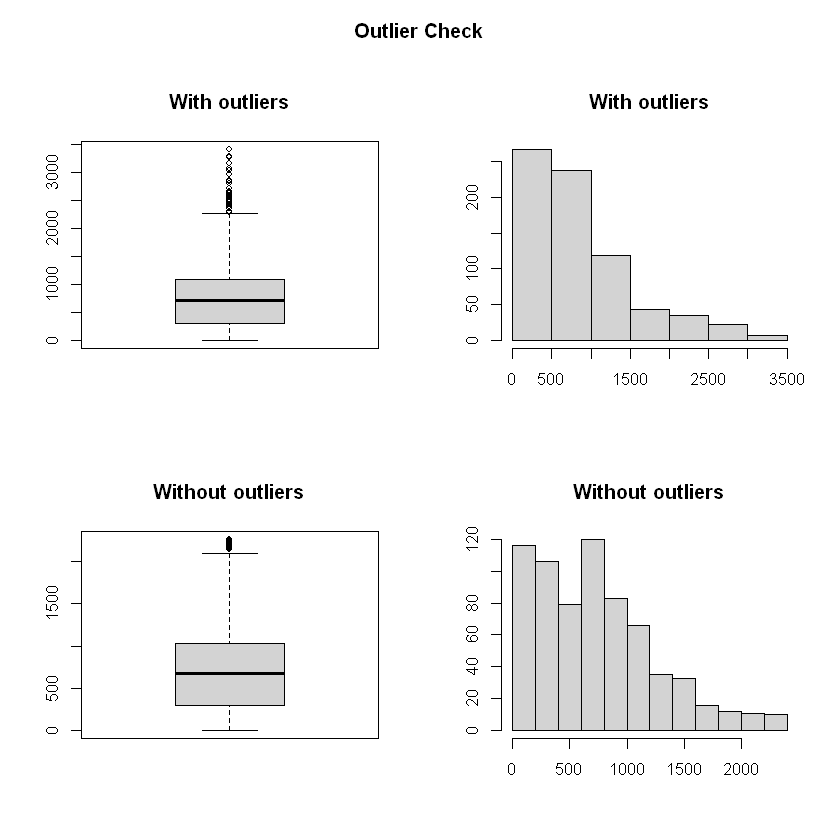

In [31]:
outlierKD(data, casual) # no logical outliers

Outliers identified: 0 nPropotion (%) of outliers: 0 nMean of the outliers: NaN nMean without removing outliers: 3656.17 nMean if we remove outliers: 3656.17 n

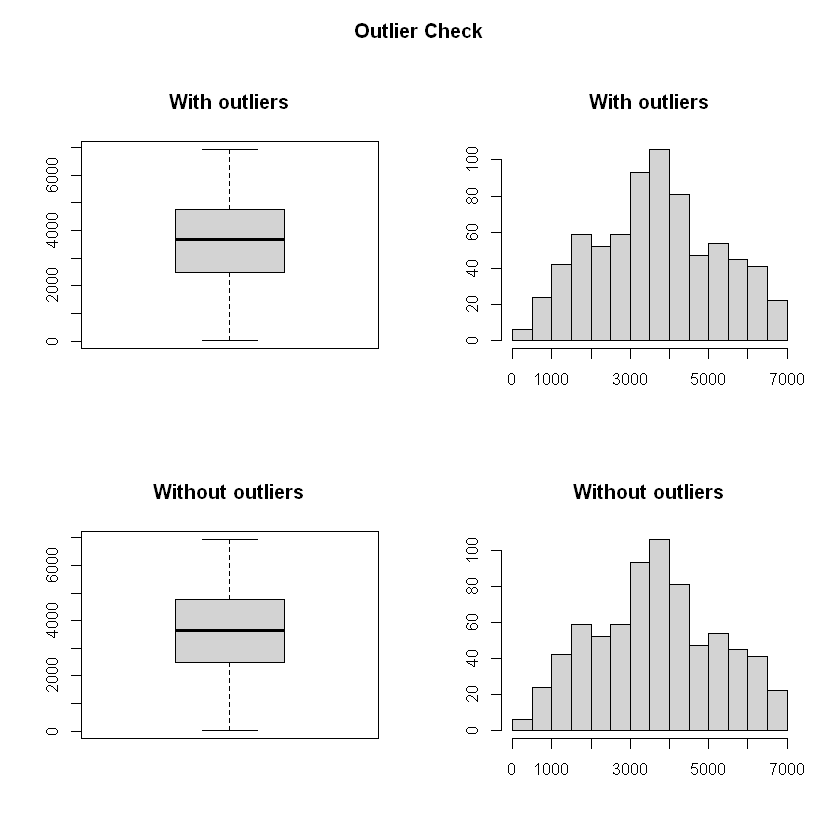

In [32]:
outlierKD(data, registered)# no ouliers

Outliers identified: 0 nPropotion (%) of outliers: 0 nMean of the outliers: NaN nMean without removing outliers: 4504.35 nMean if we remove outliers: 4504.35 n

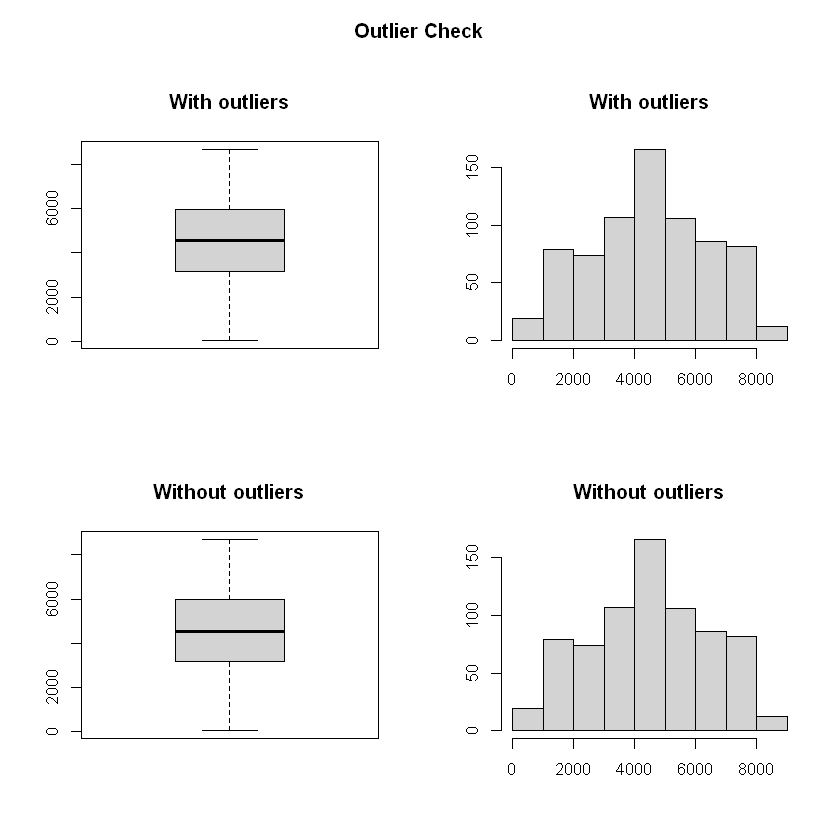

In [33]:
outlierKD(data, cnt)# no ouliers

## Correlation Analysis                                                      

In [34]:
par(mfrow = c(1, 1))
numeric_predictors <- unlist(lapply(data, is.numeric))
numVarDataset <- data[, numeric_predictors]
corr <- cor(numVarDataset)

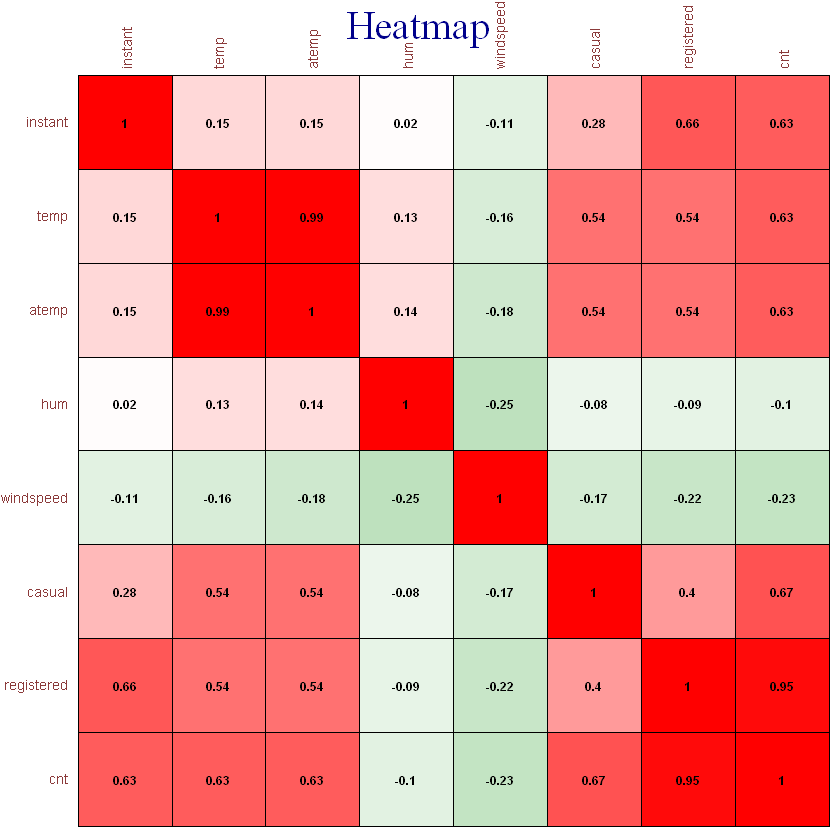

In [35]:
corrplot(
   corr,
   method = "color",
   outline = TRUE,
   cl.pos = 'n',
   rect.col = "black",
   tl.col = "indianred4",
   addCoef.col = "black",
   main="\n\nHeatmap\n", 
   col.main="darkblue", 
   font.main=6,
   cex.main=2,
   number.digits = 2,
   number.cex = 0.60,
   tl.cex = 0.70,
   cl.cex = 1,
   col = colorRampPalette(c("green4", "white", "red"))(100)
)

<h3>
    <ol>
    Findings :<br><br>
    <li>temp and atemp are highly correlated</li><br><br>
    <li>Target variable looks like normal distribution</li><br><br>
</ol>
</h3>

Warning message in geom_histogram(aes(y = after_stat(density), binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


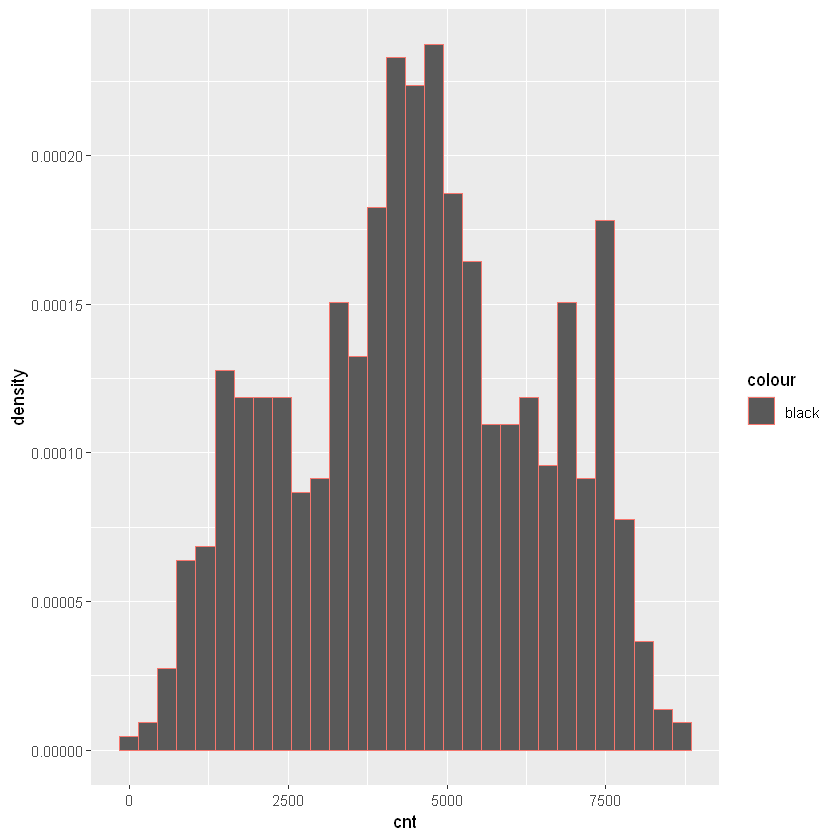

In [36]:
# Looking at target variable
ggplot(data = data, aes(cnt)) +
   geom_histogram(aes(
      y = after_stat(density),
      binwidth = .5,
      colour = "black"
   ))

In [37]:
## Univariate Analysis     
# 1. Continous predictors
univariate_continuous <- function(dataset, variable, variableName) {
   var_name = eval(substitute(variable), eval(dataset))
   print(summary(var_name))
   ggplot(data = dataset, aes(var_name)) +
      geom_histogram(aes(binwidth = .5, colour = "black")) +
      labs(x = variableName) +
      ggtitle(paste("count of", variableName))
}

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     22    3152    4548    4504    5956    8714 


Warning message in geom_histogram(aes(binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


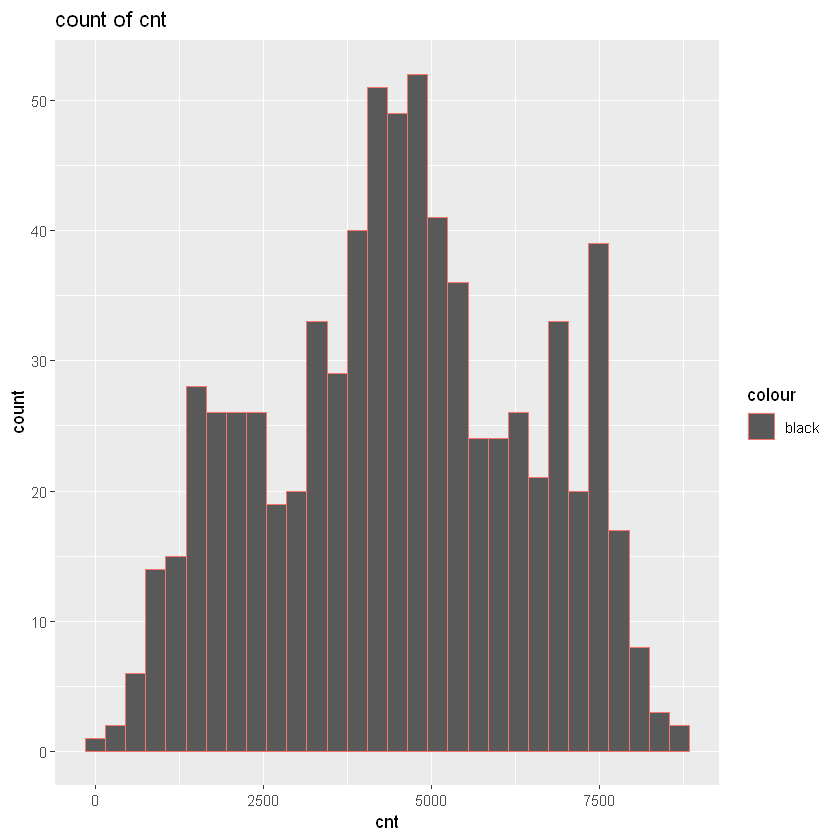

In [38]:
univariate_continuous(data, cnt, "cnt")

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.05913 0.33708 0.49833 0.49538 0.65542 0.86167 


Warning message in geom_histogram(aes(binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.07907 0.33784 0.48673 0.47435 0.60860 0.84090 


Warning message in geom_histogram(aes(binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


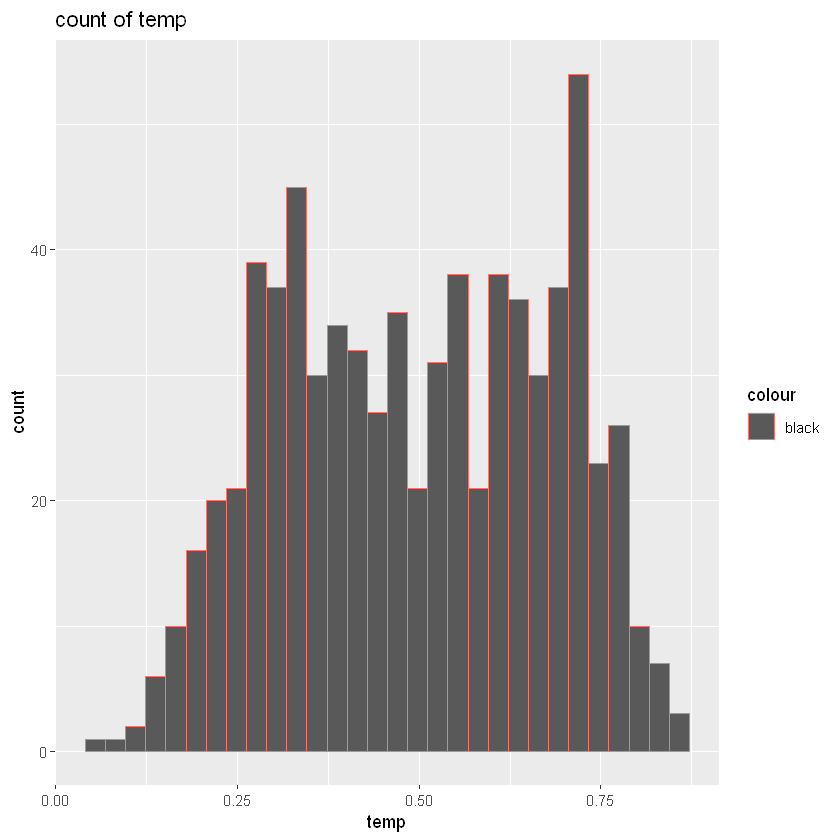

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.5200  0.6267  0.6279  0.7302  0.9725 


Warning message in geom_histogram(aes(binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


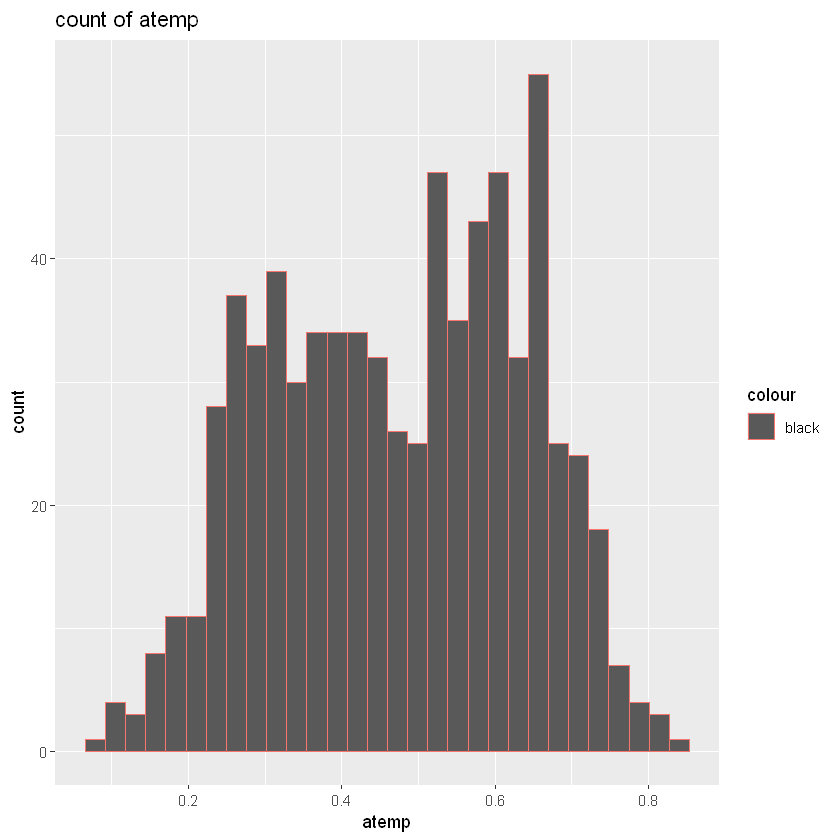

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02239 0.13495 0.18097 0.19049 0.23321 0.50746 


Warning message in geom_histogram(aes(binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


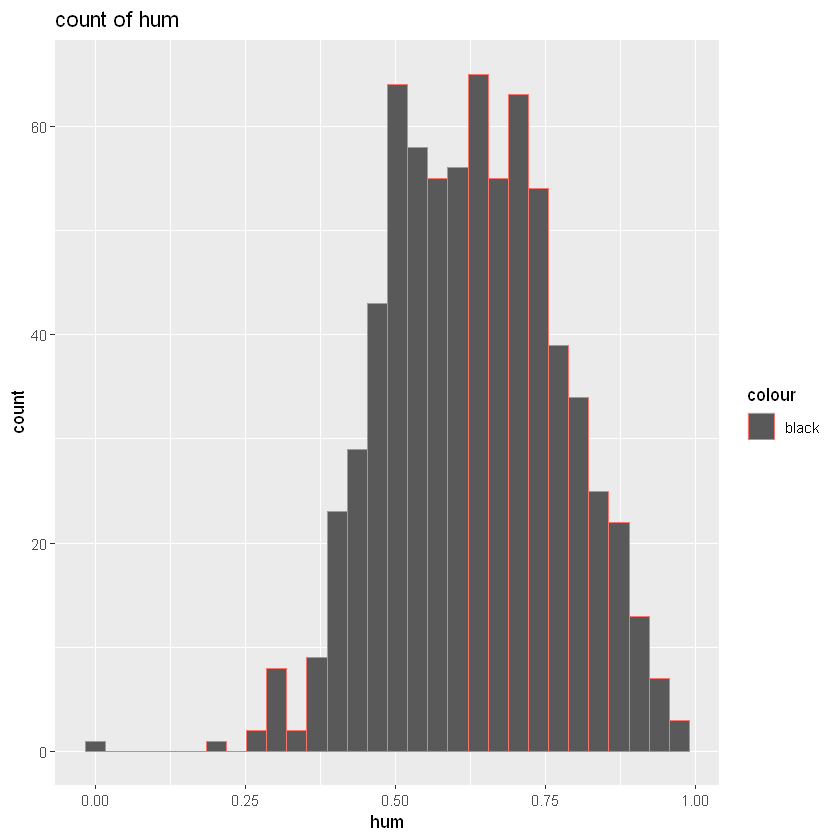

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    2.0   315.5   713.0   848.2  1096.0  3410.0 


Warning message in geom_histogram(aes(binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


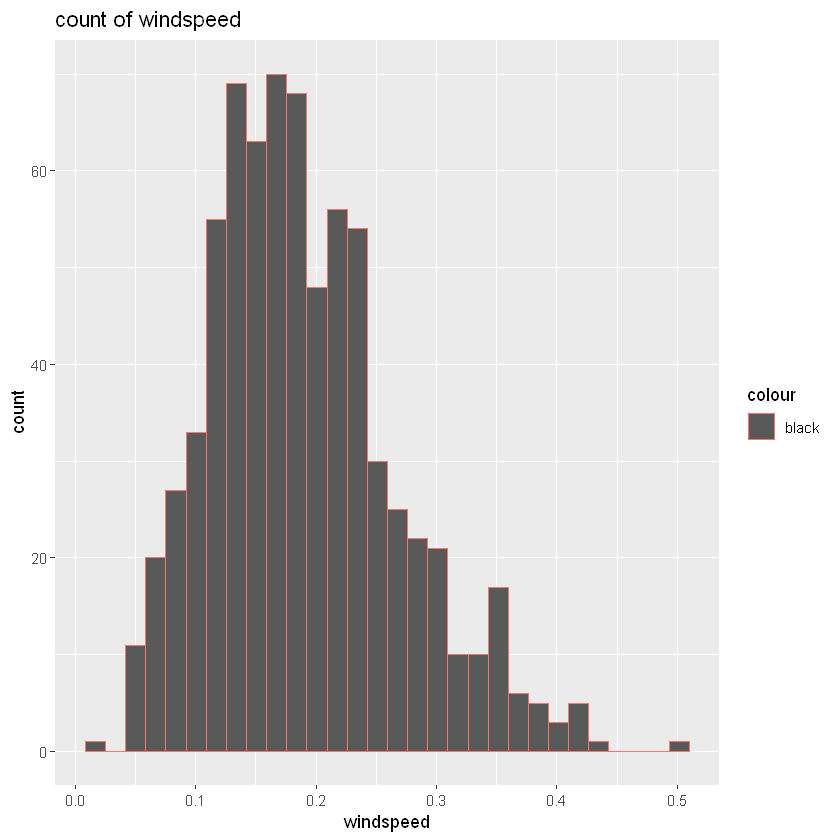

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
     20    2497    3662    3656    4776    6946 


Warning message in geom_histogram(aes(binwidth = 0.5, colour = "black")):
"Ignoring unknown aesthetics: binwidth"
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


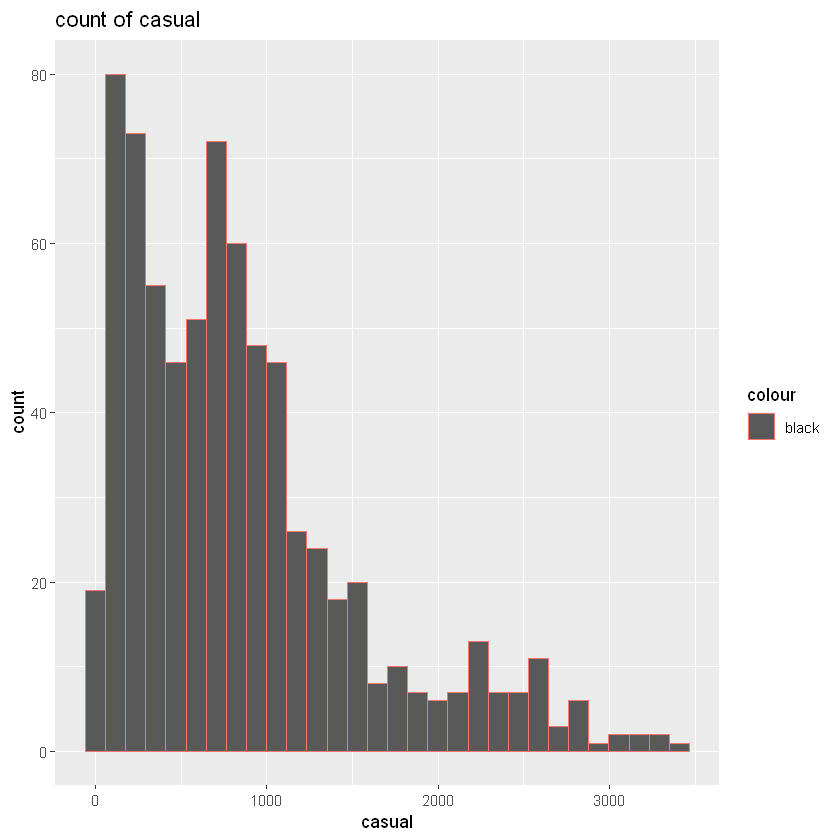

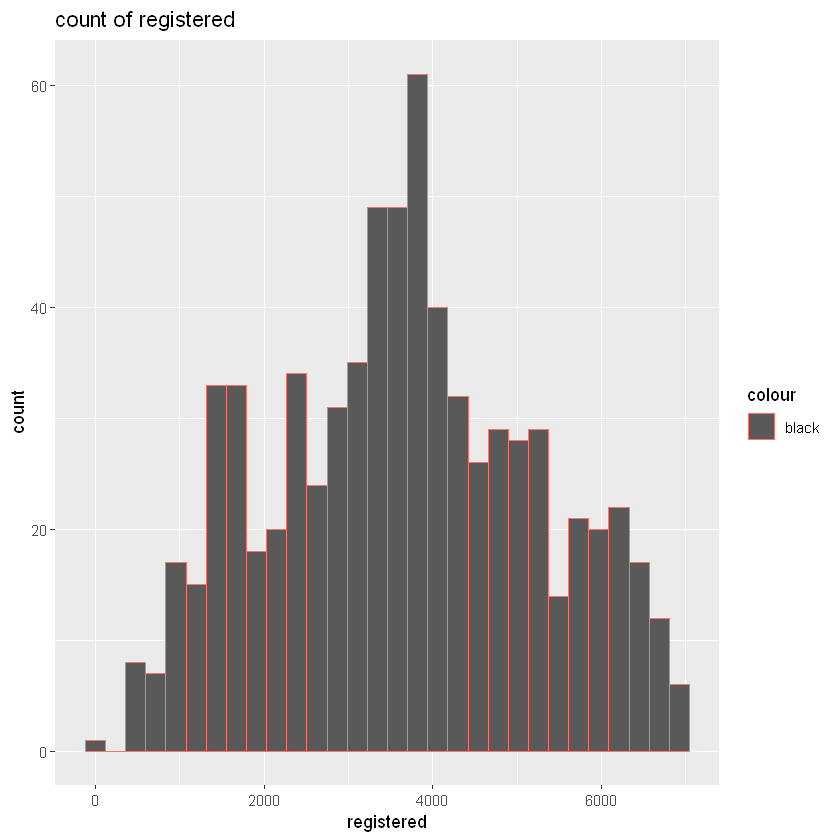

In [39]:
univariate_continuous(data, temp, "temp")
univariate_continuous(data, atemp, "atemp")
univariate_continuous(data, hum, "hum") # skwed towards left
univariate_continuous(data, windspeed, "windspeed") #skewed towards right
univariate_continuous(data, casual, "casual") # skwed towards right
univariate_continuous(data, registered, "registered")

In [40]:
#2. categorical variables
univariate_categorical  <- function(dataset, variable, variableName) {
   variable <- enquo(variable)
   
   percentage <- dataset %>%
      dplyr::select(!!variable) %>%
      group_by(!!variable) %>%
      summarise(n = n()) %>%
      mutate(percantage = (n / sum(n)) * 100)
   print(percentage)
   
   dataset %>%
      count(!!variable) %>%
      ggplot(mapping = aes_(
         x = rlang::quo_expr(variable),
         y = quote(n),
         fill = rlang::quo_expr(variable)
      )) +
      geom_bar(stat = 'identity',
               colour = 'white') +
      labs(x = variableName, y = "count") +
      ggtitle(paste("count of ", variableName)) +
      theme(legend.position = "bottom") -> p
   plot(p)
}

In [41]:
univariate_categorical(raw_data, season, 'season')
univariate_categorical(raw_data, yr, "yr")
univariate_categorical(raw_data, mnth, "mnth")
univariate_categorical(raw_data, holiday, "holiday")
univariate_categorical(raw_data, weekday, "weekday")
univariate_categorical(raw_data, workingday, "workingday")
univariate_categorical(raw_data, weathersit, "weathersit")

# ------------------------------------------------------------------------------------------------ #
#
#                                     bivariate Analysis
#
#------------------------------------------------------------------------------------------------- #

# bivariate analysis for categorical variables
bivariate_categorical <-
   function(dataset, variable, targetVariable) {
      variable <- enquo(variable)
      targetVariable <- enquo(targetVariable)
      
      ggplot(
         data = dataset,
         mapping = aes_(
            x = rlang::quo_expr(variable),
            y = rlang::quo_expr(targetVariable),
            fill = rlang::quo_expr(variable)
         )
      ) +
         geom_boxplot() +
         theme(legend.position = "bottom") -> p
      plot(p)
      
   }

bivariate_continous <-
   function(dataset, variable, targetVariable) {
      variable <- enquo(variable)
      targetVariable <- enquo(targetVariable)
      ggplot(data = dataset,
             mapping = aes_(
                x = rlang::quo_expr(variable),
                y = rlang::quo_expr(targetVariable)
             )) +
         geom_point() +
         geom_smooth() -> q
      plot(q)
      
   }

bivariate_categorical(raw_data, season, cnt)
bivariate_categorical(raw_data, yr, cnt)
bivariate_categorical(raw_data, mnth, cnt)
bivariate_categorical(raw_data, holiday, cnt)
bivariate_categorical(raw_data, weekday, cnt)
bivariate_categorical(raw_data, workingday, cnt)
bivariate_categorical(raw_data, weathersit, cnt)

bivariate_continous(raw_data, temp, cnt)
bivariate_continous(raw_data, atemp, cnt)
bivariate_continous(raw_data, hum, cnt)
bivariate_continous(raw_data, windspeed, cnt)
bivariate_continous(raw_data, casual, cnt)
bivariate_continous(raw_data, registered, cnt)


# removing instant and dteday
raw_data$instant <- NULL
raw_data$dteday <- NULL
raw_data$casual <- NULL
raw_data$registered <- NULL


# ------------------------------------------------------------------------------------------------ #
#
#                                     Feature scaling or Normalization                             #
#
#------------------------------------------------------------------------------------------------- #

scaledData <- normalizeFeatures(raw_data,'cnt')





# Function for calculating Mean Absolute Error
MAE <- function(actual,predicted){
   error = actual - predicted
   mean(abs(error))
}
# ----------------- Model 1 Linear Regression -----------------------------------------------------#


set.seed(654)
split <- sample.split(raw_data$cnt, SplitRatio = 0.70)
training_set <- subset(raw_data, split == TRUE)
test_set <- subset(raw_data, split == FALSE)


model1 <- lm(cnt ~ ., data = training_set)


# step wise model selection

modelAIC <- stepAIC(model1, direction = "both")
summary(modelAIC)




# Apply prediction on test set
test_prediction <- predict(modelAIC, newdata = test_set)


test_rmse <- rmse(test_set$cnt, test_prediction)
print(paste("root-mean-square error for linear regression model is ", test_rmse))
print(paste("Mean Absolute Error for linear regression model is ",MAE(test_set$cnt,test_prediction)))
print("summary of predicted count values")
summary(test_prediction)
print("summary of actual count values")
summary(test_set$cnt)

# From the summary we can observe negative prediction values
#We will perform log transformation of trarget variable
model2 <- lm(log(cnt)~., data = training_set)

stepwiseLogAICModel <- stepAIC(model2,direction = "both")
test_prediction_log<- predict(stepwiseLogAICModel, newdata = test_set)
predict_test_nonlog <- exp(test_prediction_log)

test_rmse2 <- rmse(test_set$cnt, predict_test_nonlog)
print(paste("root-mean-square error between actual and predicted", test_rmse))
print(paste("Mean Absolute Error for linear regression model is ",
            MAE(test_set$cnt,predict_test_nonlog)))

summary(predict_test_nonlog)
summary(test_set$cnt)



par(mfrow = c(2, 2))
plot(stepwiseLogAICModel)

# ----------------- Model 2 Random forest -----------------------------------------------------#

rf_model_1 <- randomForest(cnt ~.,
                           data = training_set,ntree = 500, mtry = 8, importance = TRUE)
print(rf_model_1)
par(mfrow = c(1,1))
plot(rf_model_1)

cv_RF <- cv

# 300 trees selected from the plot

tumedmodel <- tuneRF(training_set[,1:11], training_set[,12], stepFactor = 0.5, plot = TRUE, 
                     ntreeTry = 250, trace = TRUE, improve = 0.05)

# selected mtry = 6 from the plot

tuned_randomForest <-  randomForest(cnt ~. - atemp,
                                    data = training_set,ntree = 250, mtry = 6, importance = TRUE)
tuned_randomForest
# predicting using random forest model 1
rf1_prediction <- predict(tuned_randomForest,test_set[,-12])
rmse(rf1_prediction,test_set$cnt)
print(paste("Mean Absolute Error for Random forest regressor  is ",
            MAE(test_set$cnt,rf1_prediction)))

#745

varImpPlot(tuned_randomForest)


# Random forest is performing better than linear regression.

ERROR: Error in eval(expr, envir, enclos): object 'raw_data' not found
